In [12]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from utils.data_generation import generate_vectors, generate_scalars
from benchmark_functions.sphere import sphere_func
from neural_network_models.feedforward_nn import FeedforwardNN

# Generating data

In [13]:
np.random.seed(1000)
torch.manual_seed(1000)

In [14]:
# data config
input_dimention = 4
domain = [-5, 5]

data_set_size = 1_000

# training, validation, test split config
training_set_fraction = 0.7
validation_set_fraction = 0.15
test_set_fraction = 0.15

batch_size = 8

# noise config
noise_mean = 0
noise_std_deviation = 0.5

In [15]:
# generate training data
data_set_vectors = generate_vectors(input_dimention, domain, data_set_size)
data_set_scalars = generate_scalars(data_set_vectors, sphere_func)

# generate noise
noise = np.random.normal(noise_mean, noise_std_deviation, data_set_size)
noisy_scalars = data_set_scalars + noise

# separate training data from validation and test data
training_set_vectors, temp_set_vectors, training_set_scalars, temp_set_scalars = train_test_split(
    data_set_vectors, 
    data_set_scalars, 
    test_size = (validation_set_fraction + test_set_fraction), 
    random_state = 42
)

# separate validation data from test data
validation_set_vectors, test_set_vectors, validation_set_scalars, test_set_scalars = train_test_split(
    temp_set_vectors, 
    temp_set_scalars, 
    test_size = (test_set_fraction / (test_set_fraction + validation_set_fraction)), 
    random_state = 42
)

# Data pre-processing

In [16]:
vector_scaler = MinMaxScaler().fit(training_set_vectors)
scalar_scaler = MinMaxScaler().fit(training_set_scalars.reshape(-1, 1))

In [17]:
training_set_vectors = vector_scaler.transform(training_set_vectors)
validation_set_vectors = vector_scaler.transform(validation_set_vectors)
test_set_vectors = vector_scaler.transform(test_set_vectors)

In [18]:
training_set_scalars = scalar_scaler.transform(training_set_scalars.reshape(-1, 1))
validation_set_scalars = scalar_scaler.transform(validation_set_scalars.reshape(-1, 1))
test_set_scalars = scalar_scaler.transform(test_set_scalars.reshape(-1, 1))

In [19]:
# convert generated data to tensors
training_set_vectors = torch.FloatTensor(training_set_vectors)
training_set_scalars = torch.FloatTensor(training_set_scalars)

validation_set_vectors = torch.FloatTensor(validation_set_vectors)
validation_set_scalars = torch.FloatTensor(validation_set_scalars)

test_set_vectors = torch.FloatTensor(test_set_vectors)
test_set_scalars = torch.FloatTensor(test_set_scalars)

In [20]:
# combine generated data into tensor datasets
train_dataset = TensorDataset(training_set_vectors, training_set_scalars)
val_dataset = TensorDataset(validation_set_vectors, validation_set_scalars)
test_dataset = TensorDataset(test_set_vectors, test_set_scalars)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# Feedforward Neural Network

In [21]:
model = FeedforwardNN(input_neuron_num = input_dimention, h1_neuron_num = 70, output_neuron_num = 1)

loss_func = nn.MSELoss()
loss_optimization_func = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
training_losses = []
validation_losses = []

best_validation_loss = float("inf")
best_model_state = None

delta = 1e-6
epoch_limit = 100
patience_limit = 13
patience_tries = 0

for epoch in range(epoch_limit):
    # training step
    model.train()
    epoch_training_loss = 0.0

    for batch_vectors, batch_scalars in train_loader:
        # pass forward
        predictions = model(batch_vectors)
        loss = loss_func(predictions, batch_scalars)
        
        # back-propagation
        loss_optimization_func.zero_grad()
        loss.backward()
        loss_optimization_func.step()
        
        epoch_training_loss += loss.item() * batch_vectors.size(0)

    # average batch loss
    epoch_training_loss /= len(train_loader.dataset)
    training_losses.append(epoch_training_loss)

    # validation step
    epoch_validation_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for batch_vectors, batch_scalars in val_loader:
            predictions = model(validation_set_vectors)
            loss = loss_func(predictions, validation_set_scalars)
            epoch_validation_loss = loss.item()

    epoch_validation_loss /= len(val_loader.dataset)
    validation_losses.append(epoch_validation_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"[{epoch + 1}] Training loss: {epoch_training_loss:.6f} | Validation loss: {epoch_validation_loss:.6f}")

    # stop condition
    if best_model_state is None or epoch_validation_loss < best_validation_loss - delta:
        best_validation_loss = epoch_validation_loss
        best_model_state = model.state_dict()
        patience_tries = 0
    else:
        patience_tries += 1

        if patience_tries >= patience_limit:
            print(f"Early stopping at epoch {epoch + 1} (no improvement for {patience_limit} epochs).")
            break

# loading best model
model.load_state_dict(best_model_state)
print(f"Loaded best model with validation loss: {best_validation_loss:.6f}")

[10] Training loss: 0.034765 | Validation loss: 0.000194
[20] Training loss: 0.021143 | Validation loss: 0.000139
[30] Training loss: 0.002866 | Validation loss: 0.000024
[40] Training loss: 0.002724 | Validation loss: 0.000015
[50] Training loss: 0.001937 | Validation loss: 0.000007
[60] Training loss: 0.001819 | Validation loss: 0.000006
Early stopping at epoch 63 (no improvement for 13 epochs).
Loaded best model with validation loss: 0.000007


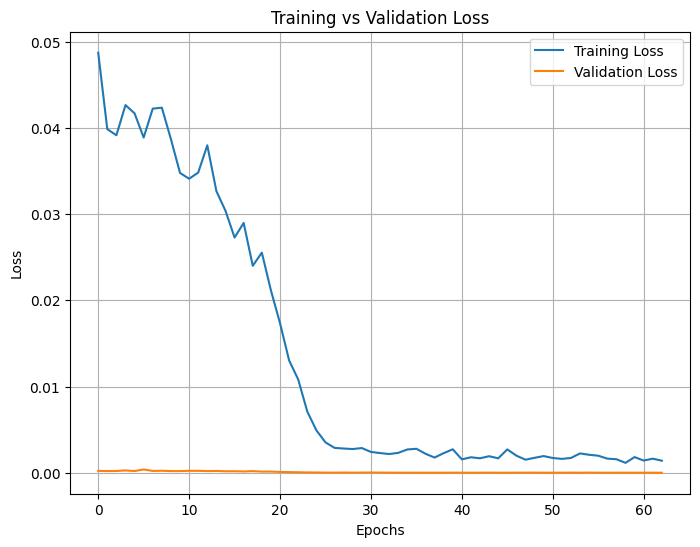

In [23]:
plt.figure(figsize = (8, 6))

plt.plot(training_losses, label = 'Training Loss')
plt.plot(validation_losses, label = 'Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)

plt.show()

In [24]:
model.eval()

with torch.no_grad():
    test_set_predictions = model(test_set_vectors)
    test_loss = loss_func(test_set_predictions, test_set_scalars)

In [25]:
test_set_predictions = test_set_predictions.numpy()
test_set_scalars = test_set_scalars.numpy()

test_set_predictions = scalar_scaler.inverse_transform(test_set_predictions)
test_set_scalars = scalar_scaler.inverse_transform(test_set_scalars)

In [26]:
absolute_errors = np.abs(test_set_predictions - test_set_scalars)

# min
min_error = np.min(absolute_errors)
print(f"Test set absolute error min: {min_error:.6f}")

# max
max_error = np.max(absolute_errors)
print(f"Test set absolute error max: {max_error:.6f}")

# mean
error_mean = np.mean(absolute_errors)
print(f"Test set absolute error mean: {error_mean:.6f}")

# standard deviation
error_std = np.std(absolute_errors)
print(f"Test set absolute error standard deviation: {error_std:.6f}")

Test set absolute error min: 0.006886
Test set absolute error max: 8.868919
Test set absolute error mean: 2.327050
Test set absolute error standard deviation: 1.592657
